##  Energy Spread Analysis

### Run this cell if you want to suppress warnings.  This is useful if the warnings print local information that you don't want to show the public but you still want to save this notebook with its output.

### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
import os
if  not './' in sys.path:
    sys.path.append('./')
if  not '../' in sys.path:
    sys.path.append('../')

from barchartacs import build_db
from barchartacs import db_info
import plotly.graph_objs as go
from plotly.offline import  init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.tools as tls
from plotly.graph_objs.layout import Font,Margin
from IPython import display
from IPython.display import HTML
import pandas as pd
import numpy as np
import datetime
import pytz
import io
from tqdm import tqdm,tqdm_notebook
from barchartacs import pg_pandas as pg
import traceback
import pandas_datareader.data as pdr
from pandas.tseries.holiday import USFederalHolidayCalendar
BUS_DAY_US = pd.offsets.CustomBusinessDay(calendar=USFederalHolidayCalendar())
TIMEZONE = 'US/Eastern'


### Instantiate an instance of pg_pandas

In [3]:
pga = db_info.get_db_info()
opttab = 'sec_schema.options_table'
futtab = 'sec_schema.underlying_table'


  sec_db


### general second order linear regression

In [4]:
def regress_2nd(x,y):
    x1 = np.array([[1 for _ in  range(len(x))],x,x**2]).T
    xm = np.matrix(x1)
    xmt = xm.T
    rgr = (np.linalg.inv(xmt @ xm) @ xmt @ np.matrix(y).T)
    
    return {f'b{i}':np.asarray(rgr[i]).reshape(-1)[0] for i in range(len(rgr))}


### Define a generalized plotly chart method

In [5]:
def plotly_plot(df_in,x_column,plot_title=None,
                y_left_label=None,y_right_label=None,
                bar_plot=False,figsize=(16,10),
                number_of_ticks_display=20,
                yaxis2_cols=None,
                center_title=False
               ):
    ya2c = [] if yaxis2_cols is None else yaxis2_cols
    ycols = [c for c in df_in.columns.values if c != x_column]
    # create tdvals, which will have x axis labels
    td = list(df_in[x_column]) 
    nt = len(df_in)-1 if number_of_ticks_display > len(df_in) else number_of_ticks_display
    spacing = len(td)//nt
    tdvals = td[::spacing]
    
    # create data for graph
    data = []
    # iterate through all ycols to append to data that gets passed to go.Figure
    for ycol in ycols:
        if bar_plot:
            b = go.Bar(x=td,y=df_in[ycol],name=ycol,yaxis='y' if ycol not in ya2c else 'y2')
        else:
            b = go.Scatter(x=td,y=df_in[ycol],name=ycol,yaxis='y' if ycol not in ya2c else 'y2')
        data.append(b)

    # create a layout
    layout = go.Layout(
        title=plot_title,
        xaxis=dict(
            ticktext=tdvals,
            tickvals=tdvals,
            tickangle=45,
            type='category'),
        yaxis=dict(
            title='y main' if y_left_label is None else y_left_label
        ),
        yaxis2=dict(
            title='y alt' if y_right_label is None else y_right_label,
            overlaying='y',
            side='right'),
        margin=Margin(
            b=100
        )        
    )

    fig = go.Figure(data=data,layout=layout)
    if center_title:
        fig.update_layout(title_x=0.5)
    return fig


### Define some Date conversion methods

In [6]:
def yyyymmdd_to_datetime(yyyymmdd,tzone = 'US/Eastern'):
    tz = pytz.timezone(tzone)
    return datetime.datetime(int(str(yyyymmdd)[0:4]),int(str(yyyymmdd)[4:6]),int(str(yyyymmdd)[6:8]),tzinfo=tz)

def datetime_to_yyyymmdd(dt):
    y = int(dt.year)
    m = int(dt.month)
    d = int(dt.day)
    return y*100*100 + m*100 + d

ymd = yyyymmdd_to_datetime(20180403)
dt_ymd = datetime_to_yyyymmdd(ymd)
print(ymd,dt_ymd)

2018-04-03 00:00:00-04:56 20180403


### Define ```CommoditySpreadInfo```, a class that helps visualized changes in backwardation and contango

In [7]:
class CommoditySpreadInfo():
    def __init__(self,commod,num_contracts):
        self.commod = commod
        self.num_contracts = num_contracts

    def consecutive_contracts(self,first_settle_date_yyyymmdd):
        sql = f"""
        select distinct symbol from {futtab} 
        where settle_date>={first_settle_date_yyyymmdd} and 
        symbol ~* '^{self.commod}';
        """
        symbols = pga.get_sql(sql).symbol.values
        symbols_ppyym = sorted([f'{c[:(len(c)-3)]}' + f'{c[-2:]}' + f'{c[2]}' for c in symbols])[:self.num_contracts]
        symbols_ppmyy = [f'{c[:(len(c)-3)]}' + f'{c[-1]}' + f'{c[-3:-1]}' for c in symbols_ppyym]
        symbol_dict = {symbols_ppmyy[i]:{'index':i,'ppyym':symbols_ppyym[i]} for i in range(len(symbols_ppmyy))}
        return symbol_dict    
    
    def create_spread_matrix(self,calendar_days_forward,first_settle_date_yyyymmdd,price_col='close'):
        # Step 01: generate yyyymmdd's
        yyyymmdds = []
        front_contracts = []
        price_arrays = []
        current_dt = yyyymmdd_to_datetime(first_settle_date_yyyymmdd)
        end_yyyymmdd = datetime_to_yyyymmdd(current_dt + datetime.timedelta(calendar_days_forward))

        sql = f"""
        select symbol,settle_date,{price_col} from {futtab} where symbol ~* '^{self.commod}' and
         settle_date >= {first_settle_date_yyyymmdd} and settle_date <= {end_yyyymmdd};
        """
        df_all_days = pga.get_sql(sql)
        all_days = sorted(df_all_days.settle_date.unique())
    
        for i in range(len(all_days)):
            current_yyyymmdd = all_days[i]
            df_prices_per_contract_this_day = df_all_days[df_all_days.settle_date==current_yyyymmdd]
            symbols = df_prices_per_contract_this_day.symbol.unique()
            symbols_ppyym = sorted([f'{c[:(len(c)-3)]}' + f'{c[-2:]}' + f'{c[2]}' for c in symbols])[:self.num_contracts]
            symbols_sorted_by_date = [f'{c[:(len(c)-3)]}' + f'{c[-1]}' + f'{c[-3:-1]}' for c in symbols_ppyym]
            df_prices_per_contract_this_day = df_prices_per_contract_this_day[df_prices_per_contract_this_day.symbol.isin(symbols_sorted_by_date)]
            front_symbol = symbols_sorted_by_date[0]
            front_contracts.append(front_symbol)
            price_array = df_prices_per_contract_this_day[price_col].values
            price_arrays.append(price_array)
            yyyymmdds.append(current_yyyymmdd)
#             current_dt = current_dt + 1*BUS_DAY_US
        d = {'yyyymmdd':yyyymmdds,'front':front_contracts}
        m = np.array(price_arrays).T
        for i in range(len(m)):
            d[i+1] = m[i].tolist()
        df = pd.DataFrame(d)
        return df                    

ncontracts = 12
csi = CommoditySpreadInfo('CL',ncontracts)
syms = list(csi.consecutive_contracts(20180401).keys())

beg_yyyymmdd = 20140101
beg_dt = yyyymmdd_to_datetime(beg_yyyymmdd)

# num_bdays_forward = 252*6 + 21*4
# cdays = ((beg_dt + num_bdays_forward * BUS_DAY_US) - beg_dt).days

end_yyyymmdd = pga.get_sql(
    f"select max(settle_date) from {futtab} where symbol ilike 'CL%%'"
).iloc[0]['max']
end_dt = yyyymmdd_to_datetime(end_yyyymmdd)
cdays = (end_dt - beg_dt).days


df_csm_close = csi.create_spread_matrix(cdays,beg_yyyymmdd)
df_csm_high = csi.create_spread_matrix(cdays,beg_yyyymmdd,price_col='high')



2021-10-05 10:22:18,457 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


In [8]:
df_csm_close.yyyymmdd.max(),df_csm_close.yyyymmdd.min()

(20211001, 20140102)

In [29]:
df_csm_close

,yyyymmdd,front,1,2,3,4,5,6,7,8,9,10,11,12
0,20140102,CLG14,95.44,95.62,95.55,95.20,94.63,93.95,93.23,92.51,91.86,91.29,90.75,90.04
1,20140103,CLG14,93.96,94.14,94.06,93.75,93.24,92.61,91.96,91.32,90.75,90.26,89.78,89.12
2,20140106,CLG14,93.43,93.58,93.52,93.29,92.84,92.26,91.65,91.03,90.47,89.99,89.52,88.89
3,20140107,CLG14,93.67,93.84,93.71,93.39,92.84,92.16,91.48,90.80,90.17,89.61,89.08,88.39
4,20140108,CLG14,92.33,92.53,92.47,92.20,91.71,91.07,90.40,89.75,89.14,88.59,88.07,87.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1787,20210208,CLH21,57.97,57.83,57.55,57.15,56.68,56.15,55.61,55.10,54.64,54.23,53.82,53.43
1788,20210209,CLH21,58.36,58.25,57.97,57.56,57.06,56.53,55.97,55.44,54.96,54.52,54.10,53.70
1789,20210210,CLH21,58.68,58.57,58.31,57.91,57.42,56.86,56.28,55.73,55.24,54.79,54.35,53.95
1790,20210211,CLH21,58.24,58.14,57.88,57.49,57.01,56.48,55.93,55.40,54.93,54.49,54.07,53.68


In [17]:
days_to_graph = 252*2
days_to_graph = None
ed_dt = yyyymmdd_to_datetime(df_csm_close.yyyymmdd.max())
graph_end_yyyymmdd = int(datetime.datetime.strftime(ed_dt,'%Y%m%d'))
if days_to_graph is None:
    bd_dt = yyyymmdd_to_datetime(df_csm_close.yyyymmdd.min())
else:
    bd_dt = yyyymmdd_to_datetime(df_csm_close.iloc[-days_to_graph].yyyymmdd)
graph_beg_yyyymmdd =  int(datetime.datetime.strftime(bd_dt,'%Y%m%d'))
                             
                          
graph_beg_yyyymmdd,graph_end_yyyymmdd

(20140102, 20200511)

In [ ]:
def price_to_percent(df_csm):
    # turn prices of forward months into percentages of first month
    df_csm2 = df_csm.copy()
    # price cols, which are just numbers relating the each symbols position 
    #  in the forward curve, where 1 = price of front month
    price_cols = [c for c in df_csm2 if c in list(range(num_bdays_forward*2))]
    df_csm2[price_cols] = df_csm2[price_cols].apply(lambda r:pd.Series({i+1:r[i+1]/r[1] for i in range(len(r))}),axis=1)
    lambda_regress = lambda r: pd.Series(regress_2nd(np.array(price_cols),np.array([r[i] for i in price_cols])))
    df_csm2[['b0','b1','b2']] = df_csm2[price_cols].apply(lambda_regress,axis=1)
    return df_csm2

cond1 = df_csm_close.yyyymmdd>=graph_beg_yyyymmdd
cond2 = df_csm_close.yyyymmdd<=graph_end_yyyymmdd
cond = [cond1[i] and cond2[i] for i in range(len(cond1))]
df_csm_close2 = df_csm_close[cond]
df_csm_close2.index = list(range(len(df_csm_close2)))
df_csm_close_percent = price_to_percent(df_csm_close2)
price_cols = [c for c in df_csm_close2 if c in list(range(num_bdays_forward*2))]

new_cols = df_csm_close_percent[['yyyymmdd','front']].apply(lambda r:f'{r.front}_{str(r.yyyymmdd)}',axis=1)
df_skew_per_day = pd.DataFrame(df_csm_close_percent[price_cols].values.T,columns=new_cols)

graph_group_size = 25
num_groups = int(len(new_cols)/graph_group_size) + (1 if (len(new_cols) % graph_group_size) > 0 else 0)

for i in range(num_groups):
    beg_index = i * graph_group_size
    end_index = min(len(new_cols)+1,beg_index + graph_group_size)
    curr_cols = new_cols[beg_index:end_index]
    df_temp = df_skew_per_day[curr_cols]
    df_temp['x'] = df_temp.index.values
    iplot(plotly_plot(df_temp,x_column='x'))
                          

In [46]:
df_csm_close2 = df_csm_close.copy()
df_csm_12_month_spread = df_csm_close2[['yyyymmdd','front',1,12]]
df_csm_12_month_spread['spread'] = df_csm_close2[12] - df_csm_close2[1]
df_csm_12_month_spread['yyyymmdd_contract'] = df_csm_12_month_spread.yyyymmdd.astype(str) + df_csm_12_month_spread.front
df_csm_12_month_spread = df_csm_12_month_spread[['yyyymmdd','spread']]
b = str(df_csm_12_month_spread.yyyymmdd.min())
bd = f"{b[4:6]}-{b[6:8]}-{b[0:4]}"
e = str(df_csm_12_month_spread.yyyymmdd.max())
ed = f"{e[4:6]}-{e[6:8]}-{e[0:4]}"
title = f"""
WTI NYMEX Crude Month 12 - Month 1 Spread From {bd} to {ed}
<br>
<i>(Once Backwardation occurs, it tends to last for over a year)</i>
"""
fig = plotly_plot(
    df_in=df_csm_12_month_spread,x_column='yyyymmdd',
    y_left_label="Spread Price",
    plot_title=title
)
fig.update_layout(title_x=0.5)
iplot(fig)



### display the *```contango_percent```* historically, which is the percent difference between the front contract and the back contract

In [12]:
df_temp = df_csm_close_percent[['yyyymmdd','front',1,12]].copy()
df_temp['x'] = df_temp.apply(lambda r: f'{r.front}_{r.yyyymmdd}',axis=1)
df_temp['contango_percent'] = df_temp.apply(lambda r: r[12] - r[1],axis=1)
df_temp['front_close'] = df_csm_close2[1].values
iplot(plotly_plot(df_temp[['x','front_close','contango_percent']],x_column='x',yaxis2_cols=['contango_percent']))


### Display the *```b1 coefficient```*, which discribes the average slope of the forward curve.  This coefficient changes very similarly to changes in the ```*coefficient percent```* above.

In [13]:
df_temp = df_csm_close_percent[['yyyymmdd','front','b1']].copy()
df_temp['x'] = df_temp.apply(lambda r: f'{r.front}_{r.yyyymmdd}',axis=1)
df_temp['front_close'] = df_csm_close2[1].values
iplot(plotly_plot(df_temp[['x','front_close','b1']],x_column='x',yaxis2_cols=['b1']))


### Display the **b2 coefficient** which discribes the curvature of the forward curve

In [14]:
df_temp = df_csm_close_percent[['yyyymmdd','front','b2']].copy()
df_temp['x'] = df_temp.apply(lambda r: f'{r.front}_{r.yyyymmdd}',axis=1)
# df_temp['contango_coefficent'] = df_temp.apply(lambda r: (r.b1 + r.b2)*1000,axis=1)
b2_magnify = 1000 #df_temp.iloc[0].b1/df_temp.iloc[0].b2
df_temp.b2 = df_temp.b2.apply(lambda v: v*b2_magnify)
df_temp['front_close'] = df_csm_close2[1].values
# iplot(plotly_plot(df_temp[['x','front_close','contango_coefficent']],x_column='x',yaxis2_cols=['contango_coefficent']))
iplot(plotly_plot(df_temp[['x','front_close','b2']],x_column='x',yaxis2_cols=['b2']))


### What are the largest single day Crack spread moves

In [90]:
def _get_sym(sym_2_char):    
    sql = f"""
    select settle_date,symbol,close from {futtab} where symbol like '{sym_2_char}%%'
    """
    df = pga.get_sql(sql)
    df = df[df.symbol!='RBZ99']
    df['sym2'] = [s[0:2]+s[3:5]+s[2] for s in df.symbol.values]
    df = df.sort_values(['settle_date','sym2'])
    df = df.groupby('settle_date',as_index=False).apply(lambda df2:df2.iloc[0]).reset_index()
    df = df.rename(columns={'close':sym_2_char})
    return df[['settle_date','sym2',sym_2_char]]


In [91]:
df_rb = _get_sym('RB')
df_cl = _get_sym('CL')

In [92]:
df_rb2 = df_rb.copy()
df_cl2 = df_cl.copy()
df_rb2.sym2 = df_rb2.sym2.str.slice(2,)
df_cl2.sym2 = df_cl2.sym2.str.slice(2,)

In [101]:
df_cl2

,settle_date,sym2,CL
0,20100901,10V,73.91
1,20100902,10V,75.02
2,20100903,10V,74.60
3,20100907,10V,74.09
4,20100909,10V,74.25
...,...,...,...
2627,20210208,21H,57.97
2628,20210209,21H,58.36
2629,20210210,21H,58.68
2630,20210211,21H,58.24


In [109]:
df_both = df_rb2.merge(df_cl2,on=['settle_date','sym2'],how='inner')
df_both['crack'] = df_both.RB*42 - df_both.CL
df_both = df_both[['sym2','crack']].groupby('sym2',as_index=False).agg([min,max]).reset_index()
df_both.columns = df_both.columns.droplevel()
df_both.columns = ['yym','min','max']
df_both

,yym,min,max
0,10V,5.4322,7.1032
1,10X,5.6992,8.7410
2,10Z,4.4370,11.7386
3,11F,8.1688,11.0576
4,11G,10.3966,14.2260
...,...,...,...
120,20X,7.9866,11.2042
121,20Z,6.8256,8.7922
122,21F,6.7068,9.9402
123,21G,10.0418,12.5366


In [116]:
pt = """
Maximum Values for each Front month RB Crack<br>From 2010 to 2021
"""
plotly_plot(
    df_both[['yym','max']],x_column='yym',bar_plot=True,
    plot_title=pt,y_left_label='Crack Price (Dollars)',
    center_title=True
)


### Get Front Month Spread

In [ ]:
rb_sql = f"""
select settle_date,symbol,close from {futtab} where symbol like 'RB%%'
"""
df_rb = pga.get_sql(rb_sql)


In [ ]:
df_rb = df_rb[df_rb.symbol!='RBZ99']
df_rb['sym2'] = [s[0:2]+s[4:6]+s[2:4] for s in df_rb.symbol.values]
df_rb = df_rb.sort_values(['settle_date','sym2'])
df_rb2 = df_rb.groupby('settle_date',as_index=False).apply(lambda df:df.iloc[0).reset_index()


In [70]:
df_rb2_0 = df_rb2[['settle_date','sym2','close']].groupby(
    'settle_date',as_index=False
).apply(lambda df:df.iloc[0])[['settle_date','close']].rename(columns={'close':'m1'})
df_rb2_1 = df_rb2[['settle_date','sym2','close']].groupby(
    'settle_date',as_index=False
).apply(lambda df:df.iloc[1])[['settle_date','close']].rename(columns={'close':'m2'})
df_rb3 = df_rb2_0.merge(df_rb2_1,on='settle_date',how='inner')
df_rb3

,settle_date,m1,m2
0,20100901,1.8891,1.8950
1,20100902,1.9216,1.9231
2,20100903,1.9195,1.9210
3,20100907,1.9329,1.9329
4,20100909,1.9354,1.9325
...,...,...,...
2606,20210208,1.6748,1.7835
2607,20210209,1.6736,1.7894
2608,20210210,1.6534,1.7841
2609,20210211,1.6502,1.7786


<AxesSubplot:>

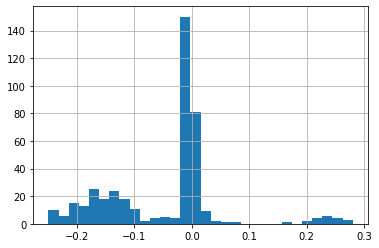

In [136]:
df_rb4 = df_rb3.copy()
df_rb4['mm'] = df_rb4.settle_date.astype(str).str.slice(4,6).astype(int)
df_rb5 = df_rb4[(df_rb4.mm>=2) & (df_rb4.mm<=3)]
df_rb5['m1_m2'] = df_rb5.m1 - df_rb5.m2
df_rb5.m1_m2.hist(bins=30)

In [137]:
df_rb5[df_rb5.m1_m2>.2]

,settle_date,m1,m2,mm,m1_m2
1364,20160202,1.2177,1.0008,2,0.2169
1365,20160203,1.2507,1.0137,2,0.2370
1366,20160204,1.2527,1.0284,2,0.2243
1367,20160205,1.2412,0.9927,2,0.2485
1368,20160208,1.2336,0.9561,2,0.2775
1369,20160209,1.1793,0.8989,2,0.2804
1370,20160210,1.1779,0.9425,2,0.2354
1371,20160211,1.1804,0.9417,2,0.2387
1372,20160212,1.2444,1.0432,2,0.2012
1373,20160216,1.2100,0.9709,2,0.2391


In [155]:
def get_sym(sym):
    df = pga.get_sql(
        f"select settle_date,close from {futtab} where symbol='{sym}'"
    ).rename(columns={'close':sym[0:3]})
    df['yy'] = sym[3:5]
    return df

df_jk_all = None    
for yy in range(10,22):
    df_j = get_sym(f'RBJ{yy}')
    df_k = get_sym(f'RBK{yy}')
    df_jk = df_j.merge(df_k, on=['settle_date','yy'],how='inner')
    if df_jk_all is None:
        df_jk_all = df_jk.copy()
    else:
        df_jk_all = df_jk_all.append(df_jk,ignore_index=True)
df_jk_all['j_k'] = df_jk_all.RBJ - df_jk_all.RBK
df_jk_all = df_jk_all.sort_values('settle_date')

In [175]:
df_jk_gb = df_jk_all[['yy','j_k']].groupby('yy',as_index=False).agg([min,max])
df_jk_gb.columns = df_jk_gb.columns.droplevel()
df_jk_gb = df_jk_gb.reset_index() 
fig = plotly_plot(df_jk_gb,x_column='yy',y_left_label='RBJ/RBK Spread',bar_plot=True,center_title=True,
           plot_title="Min and Max of RB J/K Spread Each Year")
fig.update_layout(
    yaxis = dict(
        tickmode = 'linear',
        tick0 = 0.025,
        dtick = 0.025
    )
)
iplot(fig)

### How often has any contract settled between 99.10 and 100.10??

In [179]:
sql = f"""
select symbol,max(settle_date),
last_value(close)  OVER (
        PARTITION BY symbol ORDER BY settle_date
        RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
from {futtab} where symbol like 'CL%%' group by symbol;
"""
df_last_values = pga.get_sql(sql)

ProgrammingError: (psycopg2.errors.GroupingError) column "underlying_table.close" must appear in the GROUP BY clause or be used in an aggregate function
LINE 3: last_value(close)  OVER (
                   ^

[SQL: 
select symbol,max(settle_date),
last_value(close)  OVER (
        PARTITION BY symbol ORDER BY settle_date
        RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
from sec_schema.underlying_table where symbol like 'CL%%' group by symbol;
]
(Background on this error at: http://sqlalche.me/e/f405)

In [187]:
sql = f"""
with lv as 
(
    select symbol,
    last_value(close)  OVER (
            PARTITION BY symbol ORDER BY settle_date
            RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
    from {futtab} where symbol like 'CL%%'
)
select symbol, max(last_value) as max_lv from lv group by symbol;
"""

df_last_values = pga.get_sql(sql)

In [189]:
df_last_values[(df_last_values.max_lv>=99.50) & (df_last_values.max_lv<=100.50)]

,symbol,max_lv


In [198]:
df_lv = df_last_values.sort_values('max_lv')
display.HTML(df_lv[df_lv.max_lv>99].to_html(index=False))

symbol,max_lv
CLJ14,99.43
CLM11,99.49
CLK14,102.13
CLM14,102.44
CLH14,102.92
CLK12,103.05
CLJ11,104.00
CLQ14,104.42
CLV13,104.67
CLU13,104.96


In [20]:
ho_contract_select = f'''
select settle_date,symbol from {futtab} 
where substring(symbol,1,2)='HO' and
substring(symbol,4,2) <> '99'
'''
df_ho_syms = pga.get_sql(ho_contract_select)

In [31]:
df_ho_syms['sym2'] = \
    df_ho_syms.symbol.str.slice(0,2) + \
    df_ho_syms.symbol.str.slice(3,5) + \
    df_ho_syms.symbol.str.slice(2,3)

df_ho_syms2 = df_ho_syms[['settle_date','sym2']].sort_values(
    ['settle_date','sym2']
).groupby(
    'settle_date',as_index=False
).first()

df_ho_syms2.tail(20)
df_ho_syms2.settle_date.max()

20210630

In [28]:
last_date_sql = f'''
select max(settle_date) from {futtab} 
where substring(symbol,1,2)='HO'
'''
pga.get_sql(last_date_sql)

,max
0,20210730
